Introduction: This is my analysis of a dataset of 1K PBMCs from the blood of a healthy donor, which I obtained from 10X genomics publicly available datasets. I downloaded FASTQ files and put them through the cellranger count pipeline, which I have documented separately. The input files in this document that I use to create my Seurat object are the output files of the cellranger count process. 

In [50]:
install.packages('Seurat')


The downloaded binary packages are in
	/var/folders/s2/dkj3kqms69s9b9_y9b9g3xn40000gn/T//Rtmp8w0q8t/downloaded_packages


In [51]:
install.packages("gtable")


The downloaded binary packages are in
	/var/folders/s2/dkj3kqms69s9b9_y9b9g3xn40000gn/T//Rtmp8w0q8t/downloaded_packages


In [52]:
library(Seurat)

In [53]:
library(patchwork)

In [54]:
library(dplyr)

The warning message that pops up after loading the dplyr library is pointing out the common names between this library and that of r-base and stats. It's important to note that if any of these functions are used, they will perform the way intended in dplyr, however it's possible to use the functions as defined in r-base or stats by using double colons, such as ?stats::lag.

In [55]:
#Load the data
pbmc.data <- Read10X(data.dir='/Users/merveozdemir/Desktop/1kpbmcs_practice/cellranger_outs/filtered_feature_bc_matrix')
#Initialize Seurat object
pbmc <- CreateSeuratObject(counts = pbmc.data, project = '1k_pbmcs', min.cells = 3, min.features = 200)
pbmc

An object of class Seurat 
21092 features across 1198 samples within 1 assay 
Active assay: RNA (21092 features, 0 variable features)
 1 layer present: counts

In [56]:
#QC metrics for the first 5 cells: Number of molecules and unique genes were calculated during the creation of Seurat object
#Adding another metric, which is percentage mitochondrial RNA
pbmc[['percent.mt']] <- PercentageFeatureSet(pbmc, pattern = '^MT-')
head(pbmc@meta.data, 5)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt
,<fct>,<dbl>,<int>,<dbl>
AAACCCAAGGAGAGTA-1,1k_pbmcs,12952,3914,7.103150
AAACGCTTCAGCCCAG-1,1k_pbmcs,9520,3288,4.653361
AAAGAACAGACGACTG-1,1k_pbmcs,6598,2664,4.046681
AAAGAACCAATGGCAG-1,1k_pbmcs,4415,2151,3.782559
AAAGAACGTCTGCAAT-1,1k_pbmcs,9998,3197,4.410882


Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


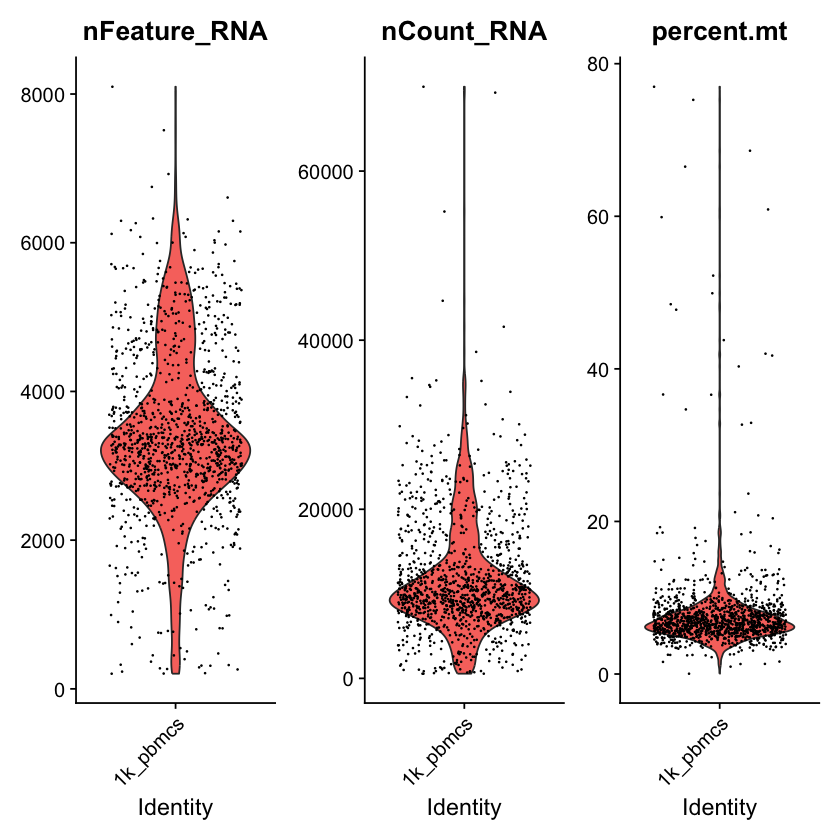

In [57]:
# Visualize QC metrics as a violin plot
VlnPlot(pbmc, features = c('nFeature_RNA', 'nCount_RNA', 'percent.mt'), ncol = 3)

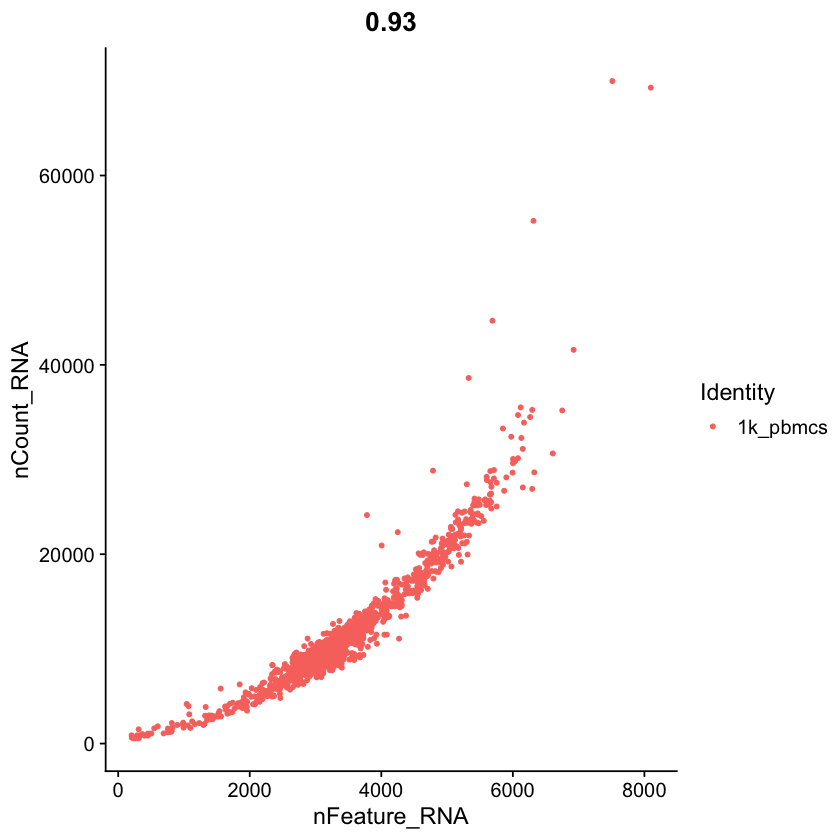

In [58]:
#Visualize as scatter plot
scatter_plot <- FeatureScatter(pbmc, feature1 = 'nFeature_RNA', feature2 = 'nCount_RNA')
scatter_plot

In [59]:
#Filter PBMCs so that you remove everything with less than 200 or more than 2500 genes, and more than 10% mitochondrial RNA.
pbmc_original <- pbmc
pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 5000 & percent.mt < 10)
pbmc

An object of class Seurat 
21092 features across 949 samples within 1 assay 
Active assay: RNA (21092 features, 0 variable features)
 1 layer present: counts

Now we can see the difference between the two pbmc datasets (one from the beginning and the filtered one now): the filtering process removed 1198-949=249 cells.

For data normalization, I will use Seurat's SCTransform function, which is a single command that replaces the NormalizeData(), ScaleData() and FindVariableFeatures() commands that I would otherwise run one by one during the normalization process. 

In [60]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("glmGamPoi")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.18 (BiocManager 1.30.25), R 4.3.2 (2023-10-31)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'glmGamPoi'”
Old packages: 'backports', 'boot', 'brio', 'broom', 'callr', 'caTools',
  'cluster', 'codetools', 'cpp11', 'DBI', 'dbplyr', 'downlit', 'dslabs',
  'foreign', 'gert', 'httr2', 'KernSmooth', 'lattice', 'matrixStats', 'mgcv',
  'nlme', 'pkgdown', 'pkgload', 'processx', 'ps', 'ragg', 'RcppArmadillo',
  'reprex', 'reticulate', 'roxygen2', 'rpart', 'rstudioapi', 'rvest',
  'spatstat.univar', 'survival', 'systemfonts', 'textshaping', 'usethis',
  'uuid', 'uwot', 'waldo', 'xopen'



In [61]:
pbmc <- SCTransform(pbmc, assay='RNA', vars.to.regress = "percent.mt", verbose = FALSE)

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’



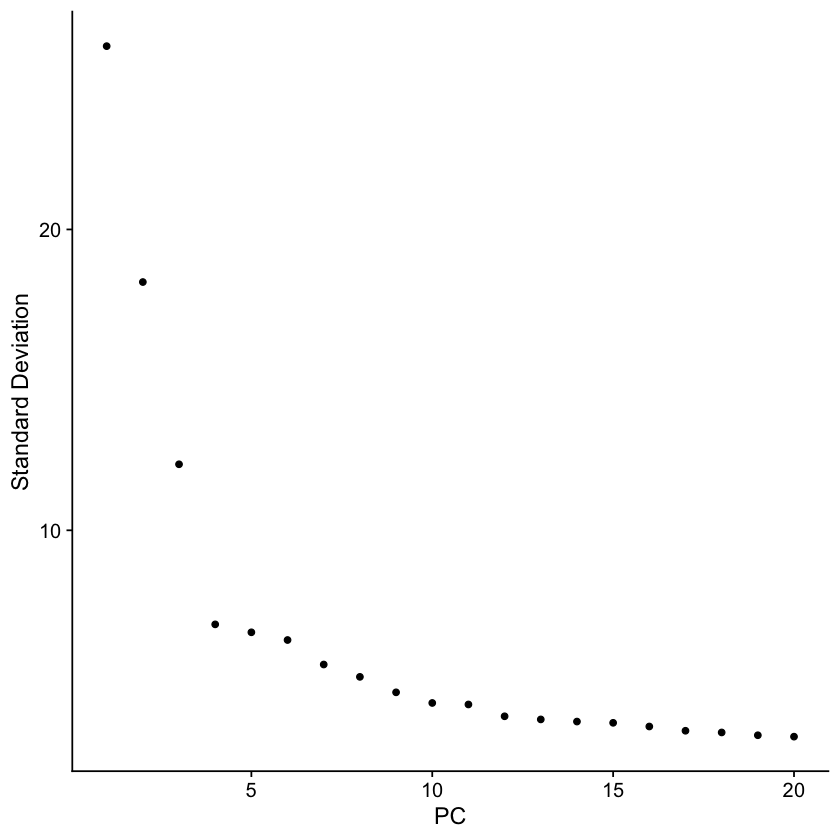

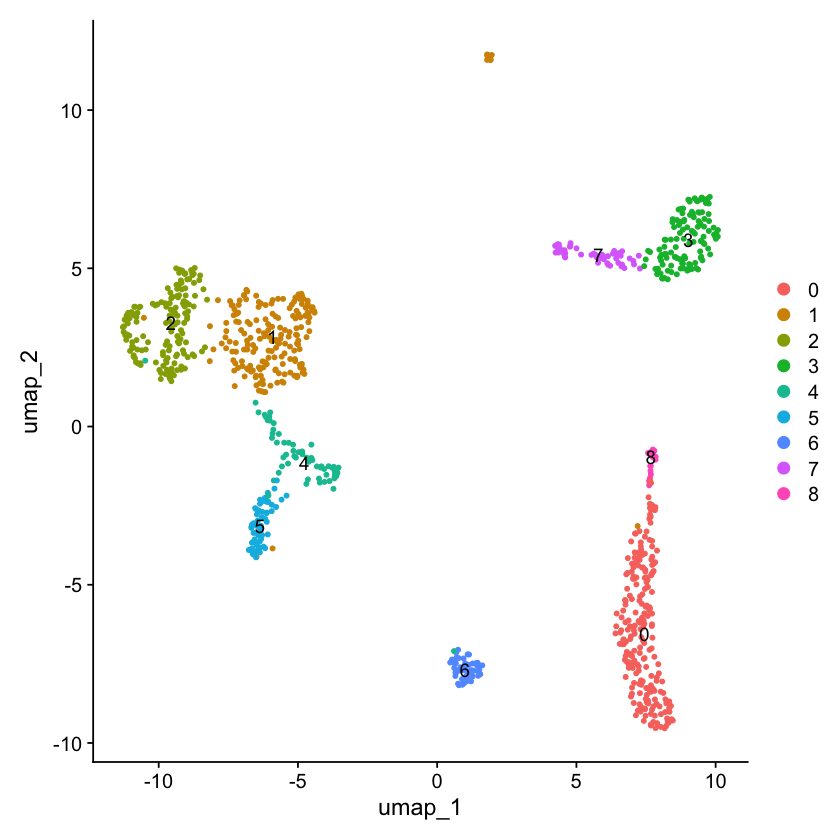

In [62]:
#Perform dimensionality reduction
pbmc <- RunPCA(object = pbmc, npcs=20, verbose=FALSE)
ElbowPlot(pbmc)

pbmc <- RunUMAP(object = pbmc, dims=1:12, verbose=FALSE)

pbmc <- FindNeighbors(pbmc, dims = 1:12, verbose = FALSE)
pbmc <- FindClusters(pbmc, resolution=0.5, verbose = FALSE)
DimPlot(pbmc, reduction='umap', label = TRUE)

In [63]:
pbmc[['pbmc_clusters_RNA']] <- Idents(pbmc)
head(pbmc, n=5)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,nCount_SCT,nFeature_SCT,SCT_snn_res.0.5,seurat_clusters,pbmc_clusters_RNA
,<fct>,<dbl>,<int>,<dbl>,<dbl>,<int>,<fct>,<fct>,<fct>
AAACCCAAGGAGAGTA-1,1k_pbmcs,12952,3914,7.103150,10743,3900,0,0,0
AAACGCTTCAGCCCAG-1,1k_pbmcs,9520,3288,4.653361,9655,3269,3,3,3
AAAGAACAGACGACTG-1,1k_pbmcs,6598,2664,4.046681,9122,2649,4,4,4
AAAGAACCAATGGCAG-1,1k_pbmcs,4415,2151,3.782559,8983,2213,4,4,4
AAAGAACGTCTGCAAT-1,1k_pbmcs,9998,3197,4.410882,9974,3177,1,1,1


In [64]:
print(pbmc[["pca"]], dims = 1:3, nfeatures = 5)

PC_ 1 
Positive:  LYZ, S100A9, CTSS, S100A8, FTL 
Negative:  RPS27, BCL11B, SKAP1, IL7R, BACH2 
PC_ 2 
Positive:  BCL11B, IL32, CD247, IL7R, IFITM1 
Negative:  CD74, HLA-DRA, BANK1, AFF3, CD79A 
PC_ 3 
Positive:  LEF1, SERINC5, PRKCA, CAMK4, INPP4B 
Negative:  NKG7, GZMA, CST7, GNLY, CTSW 


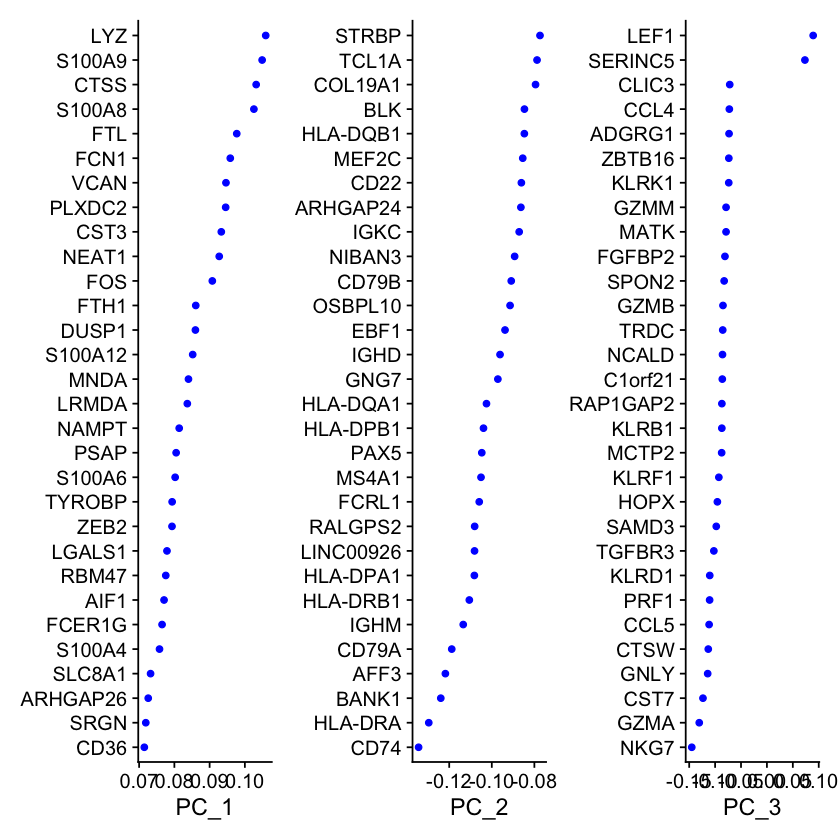

In [65]:
plot1 <- VizDimLoadings(pbmc, dims = 1, reduction = "pca")
plot2 <- VizDimLoadings(pbmc, dims = 2, reduction = "pca")
plot3 <- VizDimLoadings(pbmc, dims = 3, reduction = "pca")

combined_plot <- plot1 | plot2 | plot3
combined_plot 

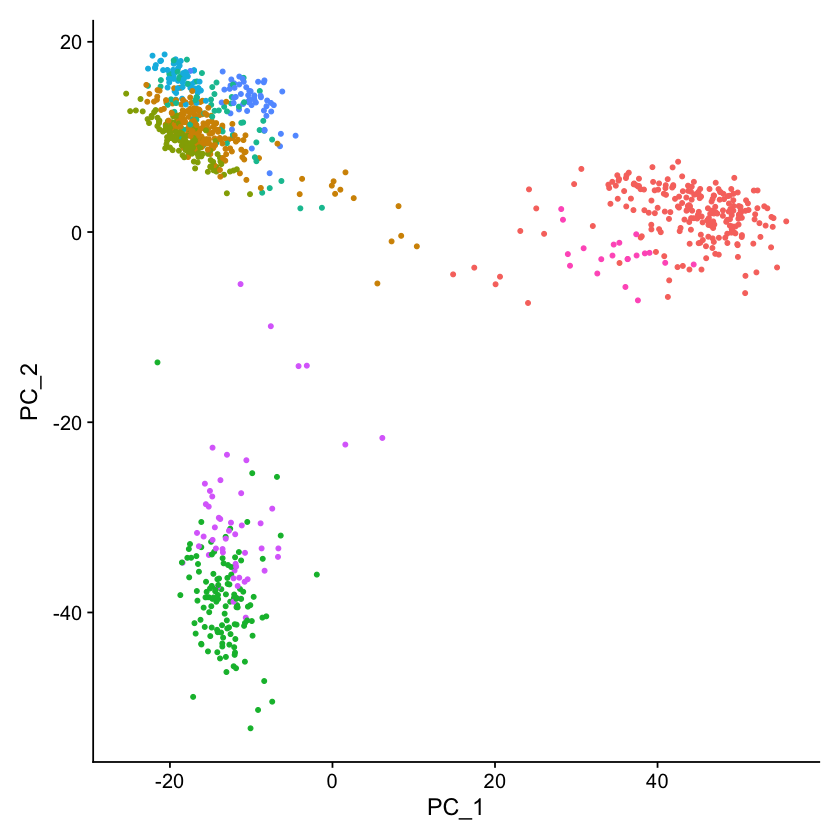

In [66]:
DimPlot(pbmc, reduction = "pca") + NoLegend()

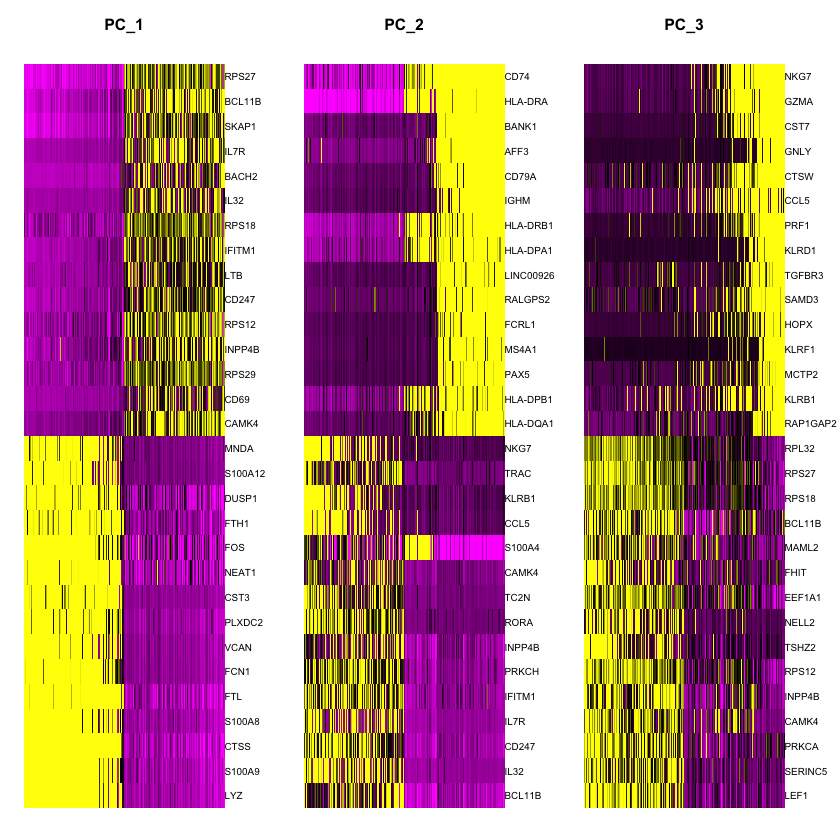

In [108]:
DimHeatmap(pbmc, dims = 1:3, cells = 500, balanced = TRUE)

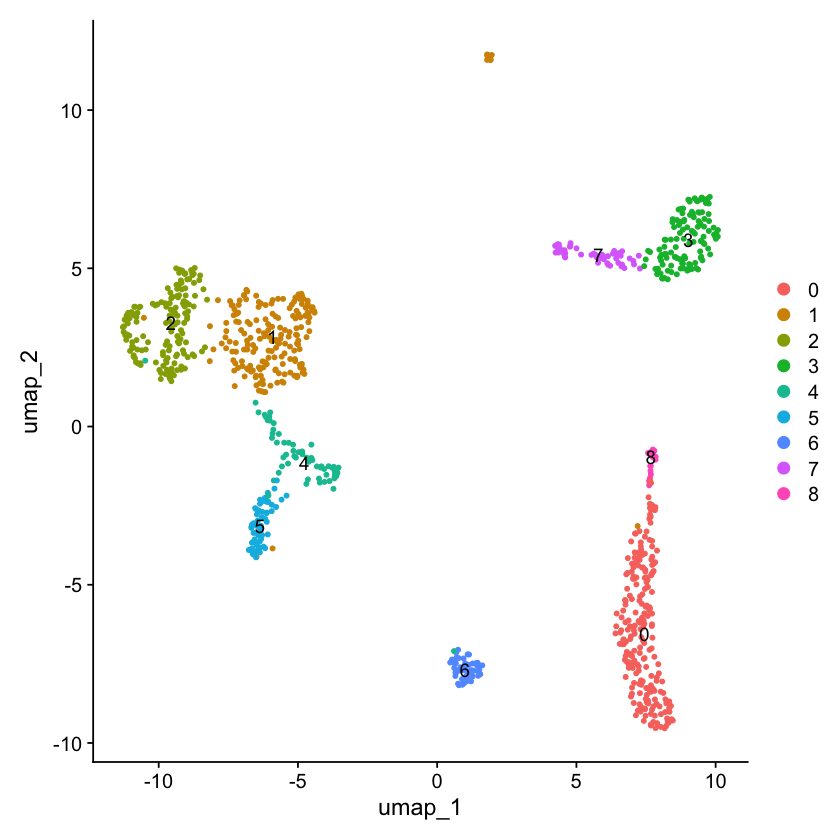

In [68]:
DimPlot(pbmc, reduction='umap', label = TRUE)

In [69]:
#Saving:
saveRDS(pbmc, file = '/Users/merveozdemir/Desktop/1kpbmcs_practice/Seurat.rds')

Now I have seen all the clusters but the DimPlot doesn't mean so much to me without knowing what they represent. Since this is PBMC data, I know that it consists of multiple cell types, and the cells of interest to me have marker genes that I can use to identify them. Below are a few I will consider:

B cells -> CD79A

Monocytes -> CST3

T cells -> CD3D

NK cells -> NCAM1, KLRD1

DCs -> ITGAX

I can see where the expression of these genes populate on my plot, which can give me a good idea of which type of cell the clusters might represent.

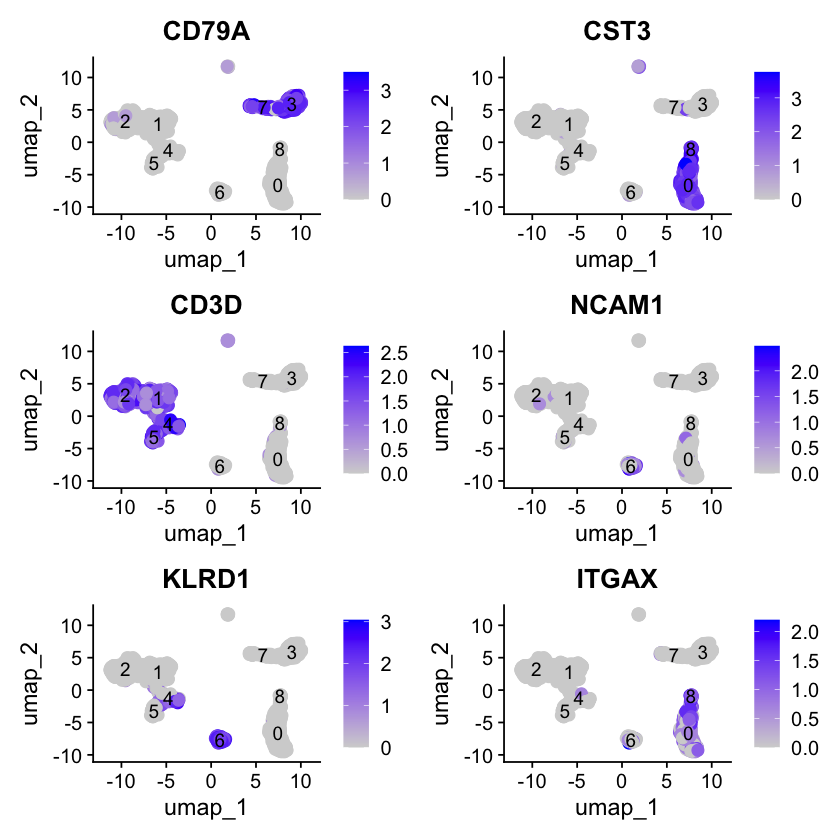

In [70]:
features <- c("CD79A", "CST3", "CD3D", "NCAM1", "KLRD1", "ITGAX")
FeaturePlot(pbmc, features = features, pt.size = 3, label = TRUE)

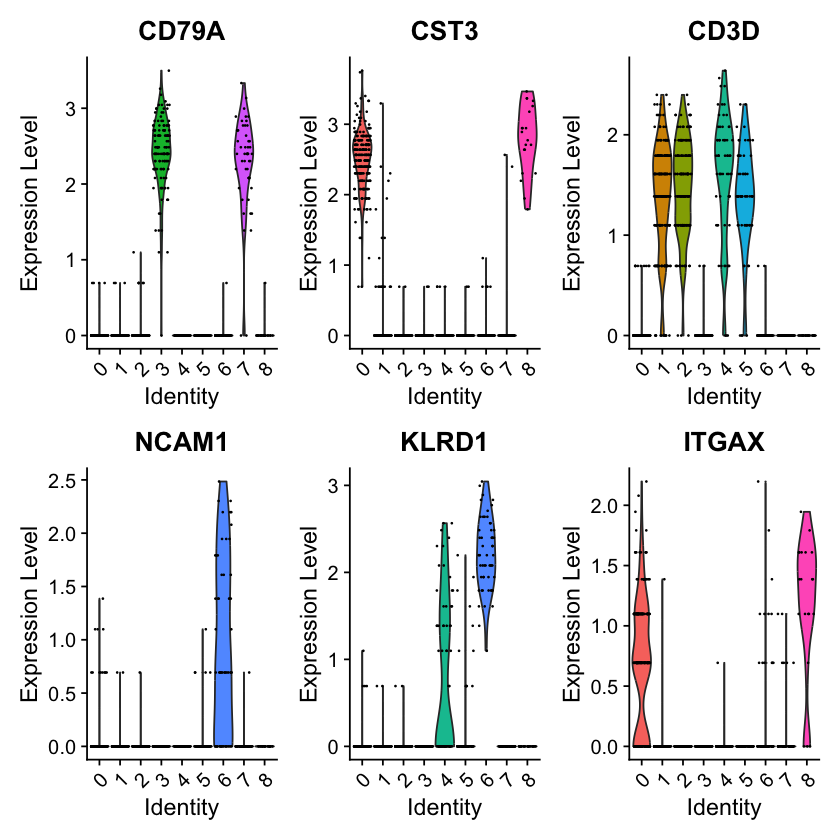

In [71]:
VlnPlot(pbmc, features=features)

I am now most interested in B cells, and see that the marker gene I used (CD79A) was expressed in both clusters 3 and 7. Although these clusters fall very close to each other on the plot, I still want to see what the differences between them are. 

In [76]:
cluster_3_markers <- FindMarkers(pbmc, ident.1=3) #if I provided an ident.2, it would just show the diffrence between two clusters
head(cluster_3_markers)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TCL1A,2.270130e-185,10.997714,0.919,0.002,4.115973e-181
IGHD,1.045328e-168,6.893637,0.976,0.033,1.895285e-164
FCRL1,2.626236e-150,5.574824,0.984,0.058,4.761628e-146
COL19A1,5.193545e-143,5.987811,0.903,0.040,9.416416e-139
PAX5,1.849547e-141,4.342100,0.984,0.055,3.353414e-137
IGHM,5.027528e-141,4.853033,0.992,0.067,9.115412e-137


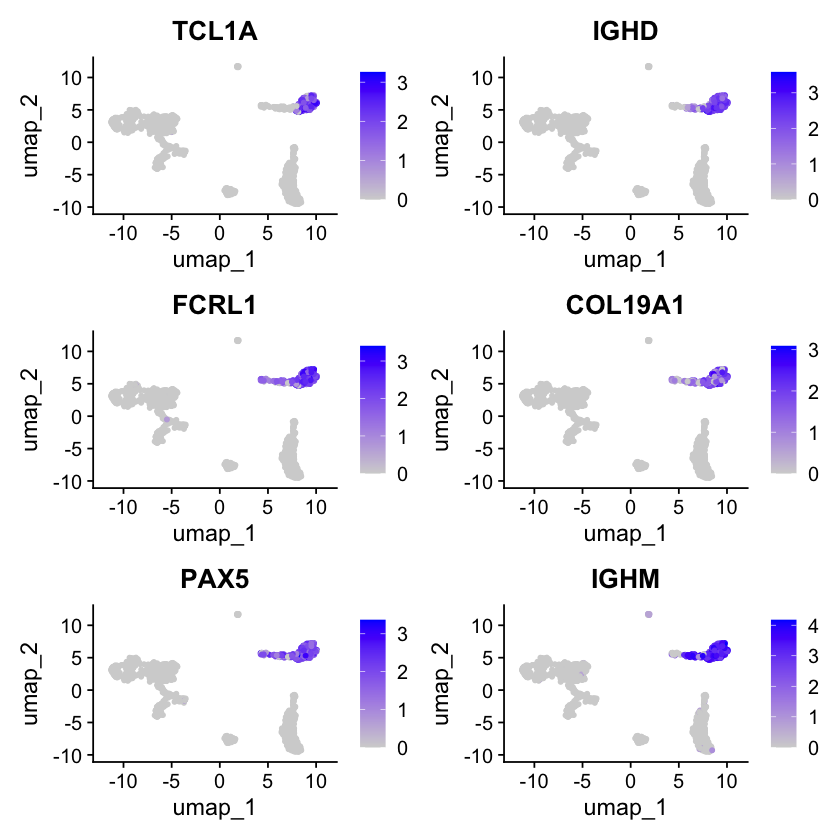

In [77]:
#Plotting the top 6 hits
FeaturePlot(pbmc, 
            reduction = "umap",
            features = rownames(head(cluster_3_markers)), 
            pt.size = 1)

Just looking at this, I can see that some of these genes are unique to Cluster 3 whereas some are spread between clusters 3 and 7, just like I had seen before with CD79A. From these 6 genes, I would only choose TCL1A and IGHD to be unique markers of Cluster 3. 

I refer to the human protein atlas website (proteinatlas.org) and search for these genes. I see that they are both markers enriched in B cells, while TCL1A is also highly expressed in DCs, and IGHD in plasma cells.

Now I can perform cell type annotation to identify cell types of all clusters.

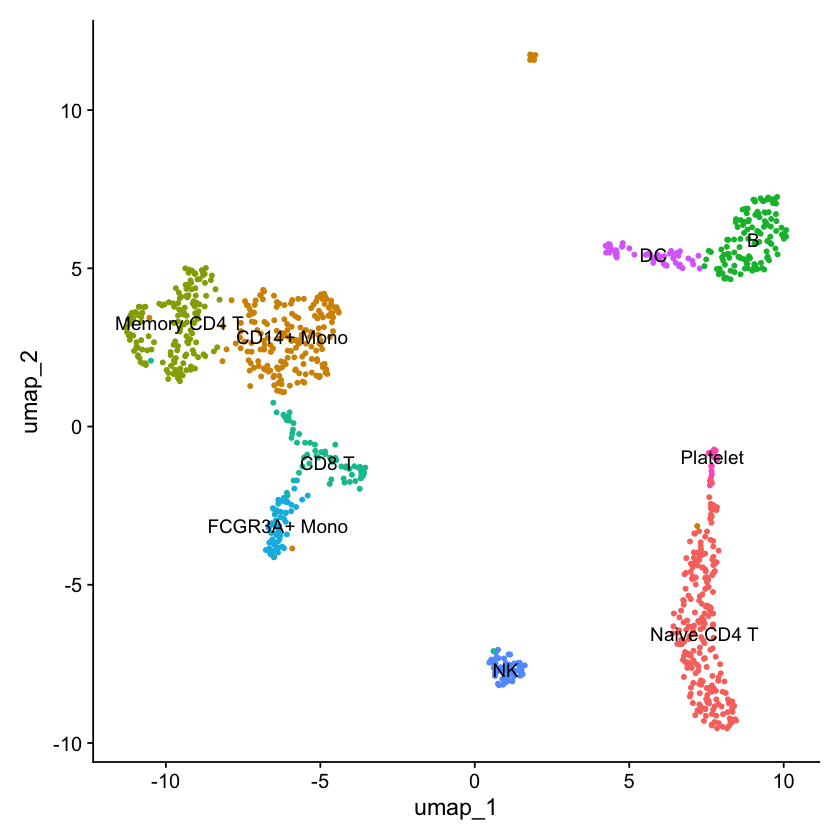

In [79]:
#Setting up the labels (cell types)
cluster_names <- c("Naive CD4 T", "CD14+ Mono", "Memory CD4 T", "B", "CD8 T", "FCGR3A+ Mono", "NK", "DC", "Platelet")
names(cluster_names) <- levels(pbmc)

#Adding the labels to the Seurat object 
pbmc <- RenameIdents(pbmc, cluster_names)

DimPlot(pbmc, reduction = "umap", label = TRUE, pt.size = 1) + NoLegend()

In [80]:
#Saving
saveRDS(pbmc, file = '/Users/merveozdemir/Desktop/1kpbmcs_practice/final.rds')

In [81]:
library(ggplot2)

I am also interested in seeing an overview of the proportions of each cell type in my dataset.

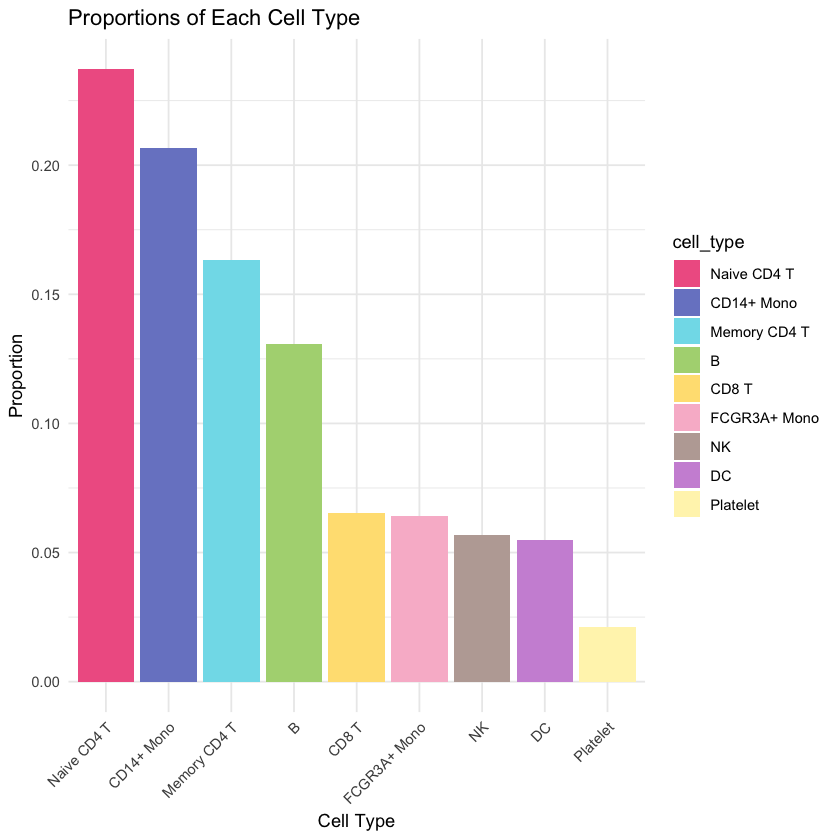

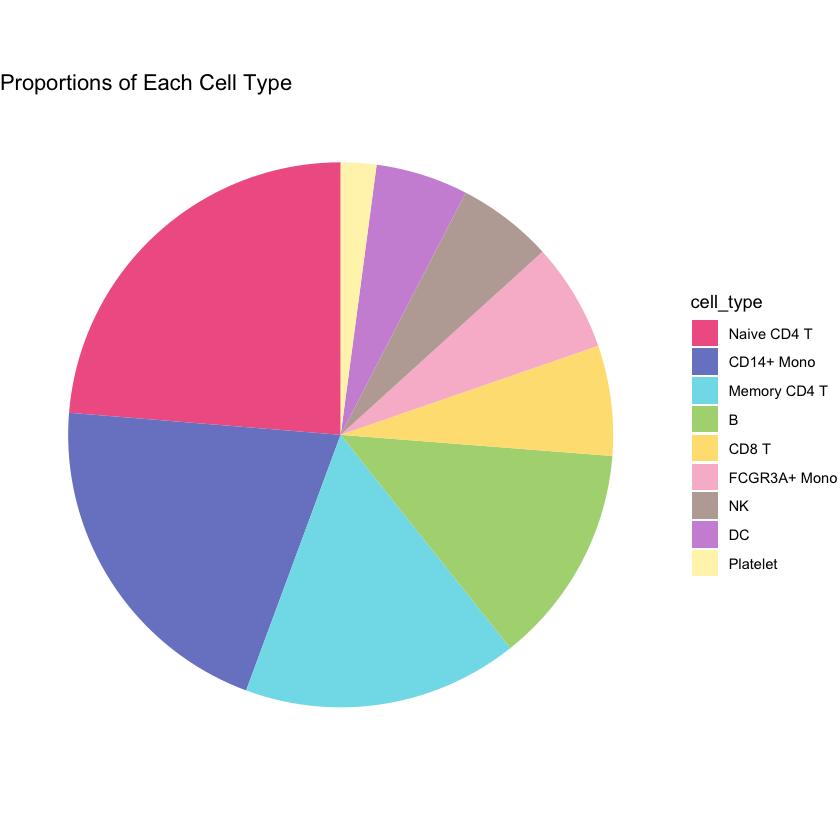

In [94]:
#Extract cell identities (cell types)
cell_types <- as.data.frame(Idents(pbmc))

#Rename the column for clarity
colnames(cell_types) <- "cell_type"

#Calculate proportions of each cell type
cell_type_proportions <- cell_types %>%
  group_by(cell_type) %>%
  summarise(count = n()) %>%
  mutate(proportion = count / sum(count))

# Define a vector of pastel colors
colors <- c("#F06292", "#7986CB", "#80DEEA", "#AED581", "#FFE082", "#F8BBD0", "#BCAAA4", "#CE93D8", "#FFF4BA")

# Create a bar plot with pastel colors
ggplot(cell_type_proportions, aes(x = cell_type, y = proportion, fill = cell_type)) +
  geom_bar(stat = "identity") +
  labs(title = "Proportions of Each Cell Type", x = "Cell Type", y = "Proportion") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  scale_fill_manual(values = colors)

# Create a pie chart with pastel colors
ggplot(cell_type_proportions, aes(x = "", y = proportion, fill = cell_type)) +
  geom_bar(stat = "identity", width = 1) +
  coord_polar(theta = "y") +
  labs(title = "Proportions of Each Cell Type") +
  theme_void() +
  scale_fill_manual(values = colors)